In [1]:
setwd("..")

In [2]:
source("Source/functions.R")
library("data.table")
library("ggplot2")
library("pheatmap")
library("viridisLite")

In [3]:
snv_info <- fread("Data/snv_loci_v2.csv")
snvIDs <- snv_info[, SNVID]
mito_barcodes <- fread("Data/mito_barcodes.csv")
mitoIDs <- mito_barcodes[, ID]

chrmbases_properties <- fread("Report/artifact/chrmbases_properties.csv.gz")
chrmbases <- chrmbases_properties[, ref]
nchrmbases <- length(chrmbases)

In [4]:
MitoInfo <- fread("Report/metadata/MitoInfo.csv")
MitoInfo[, ExptID := factor(ExptID)]
MitoInfo[, MitoID := factor(MitoID, levels = mitoIDs)]
MitoInfo[, CellID := factor(CellID)]
MitoInfo_df <- as.data.frame(MitoInfo)
rownames(MitoInfo_df) <- MitoInfo_df[, "LibraryMitoID"]

CellInfo <- fread("Report/metadata/CellInfo.csv")
CellInfo_df <- as.data.frame(CellInfo)
rownames(CellInfo_df) <- CellInfo_df$CellUID

MouseInfo <- fread("Report/metadata/MouseInfo.csv")
MouseInfo_df <- as.data.frame(MouseInfo)
rownames(MouseInfo_df) <- MouseInfo_df$MouseID

## What is the theoretical expectation of the number of SNVs shared by *k* mice?  
Let's do an empirical distribution.

In [5]:
support_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")

highdepth_qcfltd_altperc_bymito_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_qcfltd_altperc_bymito_byposmut.csv.gz")
X <- as.matrix(highdepth_qcfltd_altperc_bymito_byposmut[IsCtrl == "N", -c(1:19)])

vaf_th <- 0.05
Y <- matrix(ifelse(X >= vaf_th * 100, 1, 0), ncol = ncol(X), dimnames = dimnames(X))
Y <- data.table(highdepth_qcfltd_altperc_bymito_byposmut[IsCtrl == "N", 1:19], Y)
Z <- Y[, lapply(.SD, function(x) ifelse(any(x > 0, na.rm = TRUE), 1, 0)), keyby = "MouseID", .SDcols = 20:1051]
nperms <- 100
set.seed(2024)
res <- replicate(nperms, expr = { colSums(t(apply(Z[, -1], 1, sample))) })

nposmut_bynmice <- apply(res, 2, function(x) table(factor(x, levels = 1:support_byposmut[, max(nmice)])))
nposmut_bynmice_mean <- rowMeans(nposmut_bynmice)

NULL

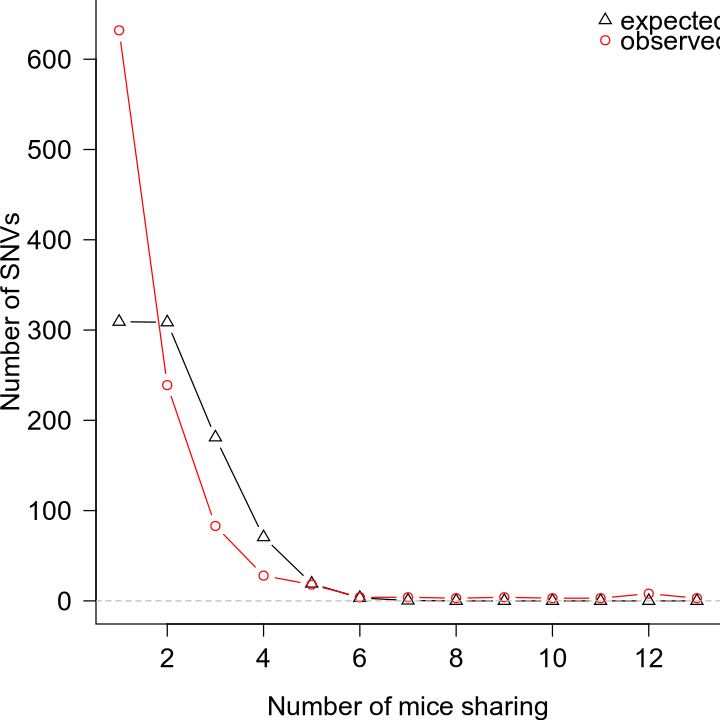

In [6]:
options(repr.plot.height = 6, repr.plot.width = 6, repr.plot.res = 72)
par(ps = 16, las = 1, lend = 2, ljoin = 1, bty = "L", mfrow = c(1, 1), mar = c(4, 4, 0, 0), oma = c(0, 0, 0, 0), mgp = c(3, 1, 0))
plot(nposmut_bynmice_mean, type = "b", xlab = "Number of mice sharing", ylab = "Number of SNVs", pch = 2, col = "black", ylim = c(0, 640))
support_byposmut[, .N, by = nmice][order(nmice)][, points(N ~ nmice, xlab = "Number of mice", ylab = "Number of SNVs", type = 'b', pch = 1, col = "red")]
abline(h = 0, lty = 2, col = "gray")
legend("topright", legend = c("expected", "observed"), pch = c(2, 1), col = c("black", "red"), box.col = NA)

## Filter total SNVs by the number of support: (1) inherited, nmice >= 3; (2) somatic nmice == 1

In [7]:
highdepth_qcfltd <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_qcfltd.csv.gz")
highdepth_qcfltd[, alt := factor(alt, levels = c("A", "C", "G", "T", "del"))]
highdepth_qcfltd[, mut := factor(paste0(ref, ">", alt), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "del")))]
highdepth_qcfltd[, posmut := paste0(pos, ":", mut)]
highdepth_qcfltd[, posmut := factor(posmut, levels = unique(posmut))]
dim(highdepth_qcfltd)

[1] 1021830      28

1. Inheirted SNVs

In [8]:
support_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
posmut_inherited <- support_byposmut[nmice >= 3, posmut]
pos_inherited <- support_byposmut[nmice >= 3, unique(pos)]

highdepth_inherited <- highdepth_qcfltd[as.character(posmut) %in% posmut_inherited]
dim(highdepth_inherited)

[1] 161934     28

In [ ]:
highdepth_inherited <- highdepth_inherited[, -c(27:28)]
fwrite(highdepth_inherited, file = "Report/SNVs/origin/highdepth_inherited.csv.gz")

In [ ]:
highdepth_qcfltd_altperc_bymito_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_qcfltd_altperc_bymito_byposmut.csv.gz")
highdepth_inherited_altperc_bymito_byposmut <- highdepth_qcfltd_altperc_bymito_byposmut[, c(1:19, match(posmut_inherited, colnames(highdepth_qcfltd_altperc_bymito_byposmut))), with = FALSE]
fwrite(highdepth_inherited_altperc_bymito_byposmut, file = "Report/SNVs/origin/highdepth_inherited_altperc_bymito_byposmut.csv.gz")

In [ ]:
highdepth_qcfltd_allele_bymito_bypos <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_qcfltd_allele_bymito_bypos.csv.gz")
highdepth_inherited_allele_bymito_bypos <- highdepth_qcfltd_allele_bymito_bypos[, c(1:19, match(pos_inherited, colnames(highdepth_qcfltd_allele_bymito_bypos))), with = FALSE]
fwrite(highdepth_inherited_allele_bymito_bypos, file = "Report/SNVs/origin/highdepth_inherited_allele_bymito_bypos.csv.gz")

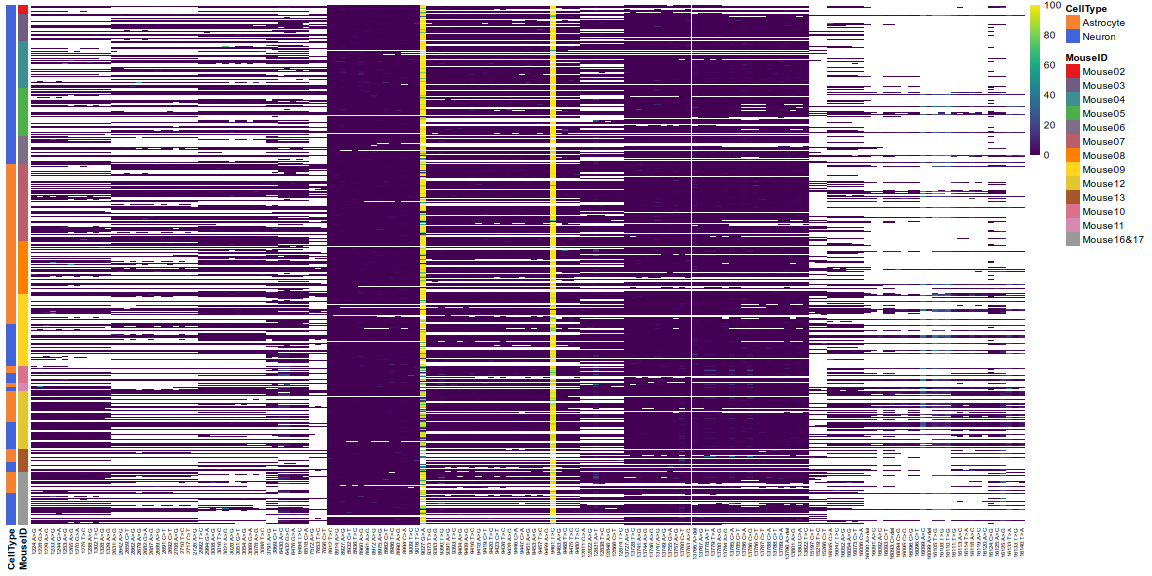

In [12]:
highdepth_inherited_noctrl_altperc_bymito_byposmut <- highdepth_inherited_altperc_bymito_byposmut[IsCtrl == "N"]
highdepth_inherited_noctrl_altperc_bymito_byposmut_df <- as.data.frame(highdepth_inherited_noctrl_altperc_bymito_byposmut[, -c(1:19)])
rownames(highdepth_inherited_noctrl_altperc_bymito_byposmut_df) <- highdepth_inherited_noctrl_altperc_bymito_byposmut[, LibraryMitoID]
MitoInfo_df <- as.data.frame(MitoInfo)
rownames(MitoInfo_df) <- MitoInfo_df$LibraryMitoID
MitoInfo_df$MitoID <- factor(MitoInfo_df$MitoID, levels = mitoIDs)
MitoInfo_df$CellID <- as.integer(MitoInfo_df$CellID)
MitoInfo_df$MouseID <- factor(MitoInfo_df$MouseID, levels = sort(MouseInfo[, MouseID]))

options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 72)
pheatmap(highdepth_inherited_noctrl_altperc_bymito_byposmut_df[with(MitoInfo_df[rownames(highdepth_inherited_noctrl_altperc_bymito_byposmut_df), ], order(MouseID, CellType, CellID, MitoID)), ], cluster_row = FALSE, cluster_col = FALSE, na_col = "#FFFFFF", annotation_row = MitoInfo_df[, c("MouseID", "CellType")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 6, show_rownames = FALSE, angle = 90, border_color = NA, breaks = seq(0, 100, length.out = 255), col = viridis(256))

2. Somatic SNVs

In [13]:
posmut_somatic <- support_byposmut[nmice == 1, posmut]
pos_somatic <- support_byposmut[nmice == 1, unique(pos)]

highdepth_somatic <- highdepth_qcfltd[as.character(posmut) %in% posmut_somatic]
dim(highdepth_somatic)

[1] 615323     28

In [ ]:
highdepth_somatic <- highdepth_somatic[, -c(27:28)]
fwrite(highdepth_somatic, file = "Report/SNVs/origin/highdepth_somatic.csv.gz")

In [ ]:
highdepth_somatic_altperc_bymito_byposmut <- highdepth_qcfltd_altperc_bymito_byposmut[, c(1:19, match(posmut_somatic, colnames(highdepth_qcfltd_altperc_bymito_byposmut))), with = FALSE]
fwrite(highdepth_somatic_altperc_bymito_byposmut, file = "Report/SNVs/origin/highdepth_somatic_altperc_bymito_byposmut.csv.gz")

In [ ]:
highdepth_somatic_allele_bymito_bypos <- highdepth_qcfltd_allele_bymito_bypos[, c(1:19, match(pos_somatic, colnames(highdepth_qcfltd_allele_bymito_bypos))), with = FALSE]
fwrite(highdepth_somatic_allele_bymito_bypos, file = "Report/SNVs/origin/highdepth_somatic_allele_bymito_bypos.csv.gz")

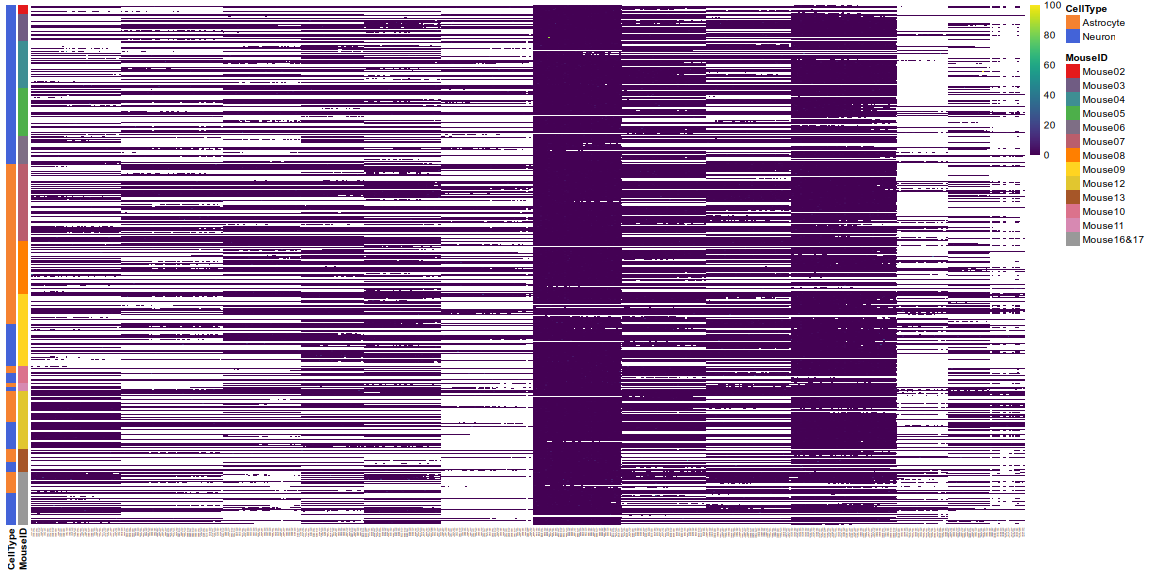

In [17]:
highdepth_somatic_noctrl_altperc_bymito_byposmut <- highdepth_somatic_altperc_bymito_byposmut[IsCtrl == "N"]
highdepth_somatic_noctrl_altperc_bymito_byposmut_df <- as.data.frame(highdepth_somatic_noctrl_altperc_bymito_byposmut[, -c(1:19)])
rownames(highdepth_somatic_noctrl_altperc_bymito_byposmut_df) <- highdepth_somatic_noctrl_altperc_bymito_byposmut[, LibraryMitoID]
MitoInfo_df <- as.data.frame(MitoInfo)
rownames(MitoInfo_df) <- MitoInfo_df$LibraryMitoID
MitoInfo_df$MitoID <- factor(MitoInfo_df$MitoID, levels = mitoIDs)
MitoInfo_df$CellID <- as.integer(MitoInfo_df$CellID)
MitoInfo_df$MouseID <- factor(MitoInfo_df$MouseID, levels = sort(MouseInfo[, MouseID]))

options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 72)
pheatmap(highdepth_somatic_noctrl_altperc_bymito_byposmut_df[with(MitoInfo_df[rownames(highdepth_somatic_noctrl_altperc_bymito_byposmut_df), ], order(MouseID, CellType, CellID, MitoID)), ], cluster_row = FALSE, cluster_col = FALSE, na_col = "#FFFFFF", annotation_row = MitoInfo_df[, c("MouseID", "CellType")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 2, show_rownames = FALSE, angle = 90, border_color = NA, breaks = seq(0, 100, length.out = 255), col = viridis(256))

## Per-site QC stats 

In [18]:
highdepth_noctrl_hasdata_bymito_bypos <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymito_bypos.csv.gz", header = TRUE)
highdepth_noctrl_hasdata_bycell_bypos <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bycell_bypos.csv.gz", header = TRUE)
highdepth_noctrl_hasdata_bymouse_bypos <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymouse_bypos.csv.gz", header = TRUE)
highdepth_noctrl_nmitoshasdata_bycell_bypos <- fread(file = "Report/SNVs/QC/highdepth_noctrl_nmitoshasdata_bycell_bypos.csv", header = TRUE)
highdepth_noctrl_ncellshasdata_bymouse_bypos <- fread(file = "Report/SNVs/QC/highdepth_noctrl_ncellshasdata_bymouse_bypos.csv", header = TRUE)
highdepth_highaf_noctrl_nvaralleles_bymito_bypos <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_nvaralleles_bymito_bypos.csv", header = TRUE)
highdepth_highaf_noctrl_nvaralleles_bycell_bypos <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_nvaralleles_bycell_bypos.csv", header = TRUE)
highdepth_highaf_noctrl_nvaralleles_bymouse_bypos <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_nvaralleles_bymouse_bypos.csv", header = TRUE)

1. Inherited SNVs

In [19]:
highdepth_inherited_noctrl_hasdata_bymito_bypos <- data.table(highdepth_noctrl_hasdata_bymito_bypos[, 1:19], highdepth_noctrl_hasdata_bymito_bypos[, match(pos_inherited, names(highdepth_noctrl_hasdata_bymito_bypos)), with = FALSE])
highdepth_inherited_noctrl_hasdata_bycell_bypos <- data.table(highdepth_noctrl_hasdata_bycell_bypos[, 1:7], highdepth_noctrl_hasdata_bycell_bypos[, match(pos_inherited, names(highdepth_noctrl_hasdata_bycell_bypos)), with = FALSE])
highdepth_inherited_noctrl_hasdata_bymouse_bypos <- data.table(highdepth_noctrl_hasdata_bymouse_bypos[, 1:2], highdepth_noctrl_hasdata_bymouse_bypos[, match(pos_inherited, names(highdepth_noctrl_hasdata_bymouse_bypos)), with = FALSE])
highdepth_inherited_noctrl_nmitoshasdata_bycell_bypos <- data.table(highdepth_noctrl_nmitoshasdata_bycell_bypos[, 1:7], highdepth_noctrl_nmitoshasdata_bycell_bypos[, match(pos_inherited, names(highdepth_noctrl_nmitoshasdata_bycell_bypos)), with = FALSE])
highdepth_inherited_noctrl_ncellshasdata_bymouse_bypos <- data.table(highdepth_noctrl_ncellshasdata_bymouse_bypos[, 1:2], highdepth_noctrl_ncellshasdata_bymouse_bypos[, match(pos_inherited, names(highdepth_noctrl_ncellshasdata_bymouse_bypos)), with = FALSE])
highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos <- data.table(highdepth_highaf_noctrl_nvaralleles_bymito_bypos[, 1:19], highdepth_highaf_noctrl_nvaralleles_bymito_bypos[, match(pos_inherited, names(highdepth_highaf_noctrl_nvaralleles_bymito_bypos)), with = FALSE])
highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos <- data.table(highdepth_highaf_noctrl_nvaralleles_bycell_bypos[, 1:7], highdepth_highaf_noctrl_nvaralleles_bycell_bypos[, match(pos_inherited, names(highdepth_highaf_noctrl_nvaralleles_bycell_bypos)), with = FALSE])
highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos <- data.table(highdepth_highaf_noctrl_nvaralleles_bymouse_bypos[, 1:2], highdepth_highaf_noctrl_nvaralleles_bymouse_bypos[, match(pos_inherited, names(highdepth_highaf_noctrl_nvaralleles_bymouse_bypos)), with = FALSE])

In [20]:
highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 2))))]

[1] "1224"  "6430"  "8960"  "9027"  "9461"  "13788" "16094" "16095" "16096"
[10] "16099" "16108" "16110" "16125" "16133"

In [21]:
highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 3))))]

[1] "9027"  "16099"

In [22]:
highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 2))))]

[1] "6430"  "8960"  "8990"  "9027"  "9419"  "9461"  "12831" "13778" "13785"
[10] "13786" "13788" "13789" "16093" "16094" "16095" "16096" "16099" "16108"
[19] "16110" "16120" "16125" "16133"

In [23]:
highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 3))))]

[1] "9027"  "16099"

In [24]:
highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 2))))]

[1] "6430"  "8960"  "8990"  "9027"  "9373"  "9393"  "9419"  "9446"  "9461" 
[10] "9463"  "12811" "12831" "13766" "13767" "13778" "13779" "13785" "13786"
[19] "13788" "13789" "13796" "16090" "16093" "16094" "16096" "16099" "16108"
[28] "16110" "16120" "16125" "16133" "16140"

In [25]:
highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 3))))]

[1] "9027"  "13785" "13786" "16095" "16099"

In [ ]:
fwrite(highdepth_inherited_noctrl_hasdata_bymito_bypos, file = "Report/SNVs/origin/highdepth_inherited_noctrl_hasdata_bymito_bypos.csv")
fwrite(highdepth_inherited_noctrl_hasdata_bycell_bypos, file = "Report/SNVs/origin/highdepth_inherited_noctrl_hasdata_bycell_bypos.csv")
fwrite(highdepth_inherited_noctrl_hasdata_bymouse_bypos, file = "Report/SNVs/origin/highdepth_inherited_noctrl_hasdata_bymouse_bypos.csv")
fwrite(highdepth_inherited_noctrl_nmitoshasdata_bycell_bypos, file = "Report/SNVs/origin/highdepth_inherited_noctrl_nmitoshasdata_bycell_bypos.csv")
fwrite(highdepth_inherited_noctrl_ncellshasdata_bymouse_bypos, file = "Report/SNVs/origin/highdepth_inherited_noctrl_ncellshasdata_bymouse_bypos.csv")
fwrite(highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos.csv")
fwrite(highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos.csv")
fwrite(highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos.csv")

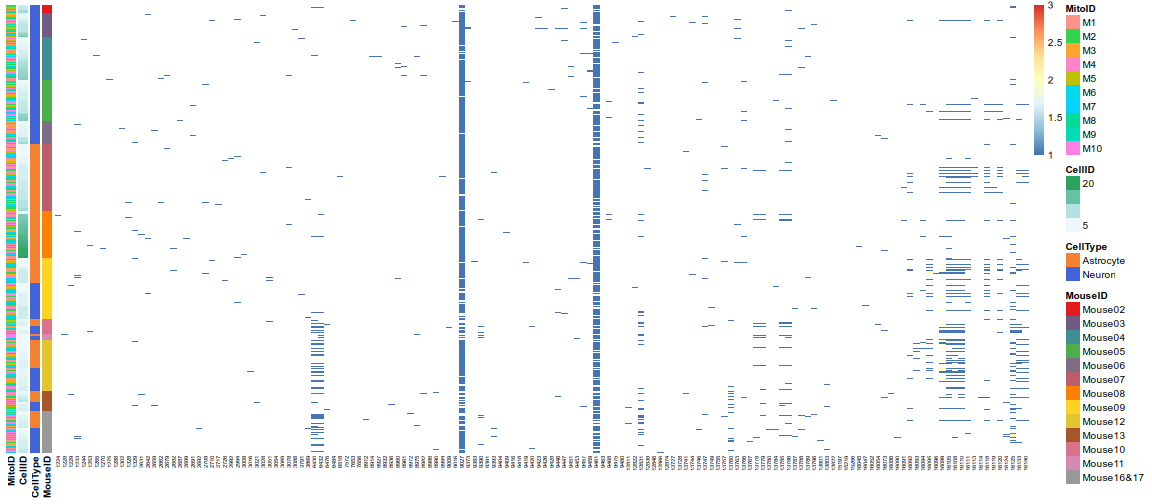

In [27]:
highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos_df <- as.data.frame(highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos[, -c(1:19)])
highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos_df[highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos_df == 0] <- NA
rownames(highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos_df) <- highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos[, LibraryMitoID]
MitoInfo_df <- as.data.frame(MitoInfo)
rownames(MitoInfo_df) <- MitoInfo_df$LibraryMitoID
MitoInfo_df$MitoID <- factor(MitoInfo_df$MitoID, levels = mitoIDs)
MitoInfo_df$CellID <- as.integer(MitoInfo_df$CellID)
highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos_df <- highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos_df[highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos[, order(MouseID, CellType, CellID, MitoID)], ]
options(repr.plot.width = 16, repr.plot.height = 7, repr.plot.res = 72)
pheatmap(highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = MitoInfo_df[rownames(highdepth_highaf_inherited_noctrl_nvaralleles_bymito_bypos_df), c("MouseID", "CellType", "CellID", "MitoID")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 6, show_rownames = FALSE, na_col = "#FFFFFFFF")

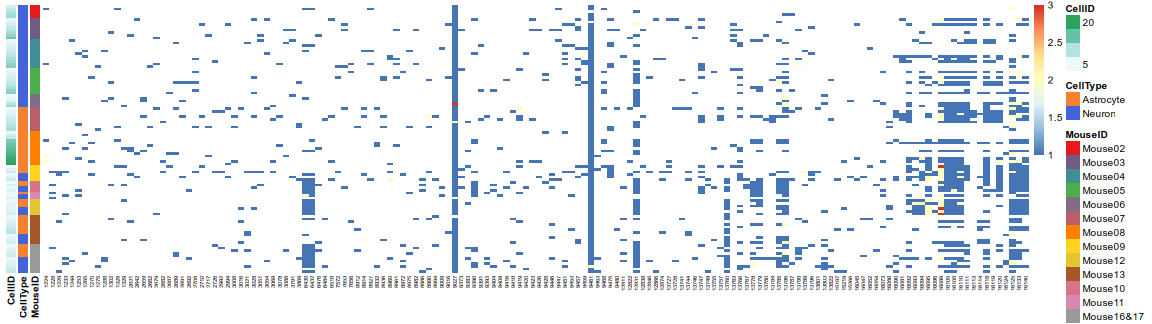

In [28]:
highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos_df <- as.data.frame(highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos[, -c(1:7)])
highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos_df[highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos_df == 0] <- NA
rownames(highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos_df) <- highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos[, CellUID]
highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos_df <- highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos_df[highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos[, order(MouseID, CellType, CellID)], ]
options(repr.plot.width = 16, repr.plot.height = 4.5, repr.plot.res = 72)
pheatmap(highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = CellInfo_df[rownames(highdepth_highaf_inherited_noctrl_nvaralleles_bycell_bypos_df), c("MouseID", "CellType", "CellID")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 6, show_rownames = FALSE, na_col = "#FFFFFFFF")

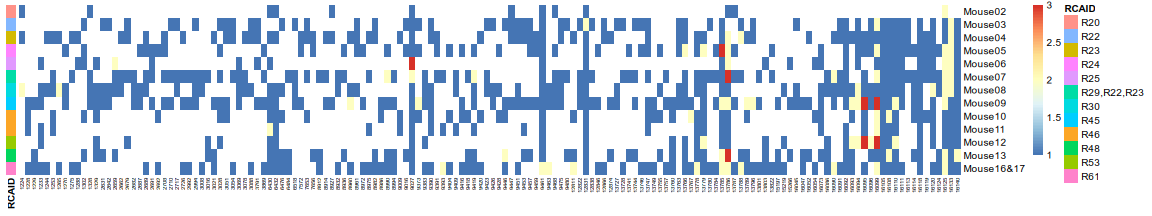

In [29]:
highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df <- as.data.frame(highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos)
highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df[highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df == 0] <- NA
rownames(highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df) <- highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos[, MouseID]
highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df <- highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df[, -c(1:2)]
highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df <- highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df[highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos[, order(MouseID)], ]
options(repr.plot.width = 16, repr.plot.height = 3, repr.plot.res = 72)
pheatmap(highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = MouseInfo_df[rownames(highdepth_highaf_inherited_noctrl_nvaralleles_bymouse_bypos_df), c("RCAID"), drop = FALSE], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 6, show_rownames = TRUE, na_col = "#FFFFFFFF")

2. Somatic SNVs

In [30]:
highdepth_somatic_noctrl_hasdata_bymito_bypos <- data.table(highdepth_noctrl_hasdata_bymito_bypos[, 1:19], highdepth_noctrl_hasdata_bymito_bypos[, match(pos_somatic, names(highdepth_noctrl_hasdata_bymito_bypos)), with = FALSE])
highdepth_somatic_noctrl_hasdata_bycell_bypos <- data.table(highdepth_noctrl_hasdata_bycell_bypos[, 1:7], highdepth_noctrl_hasdata_bycell_bypos[, match(pos_somatic, names(highdepth_noctrl_hasdata_bycell_bypos)), with = FALSE])
highdepth_somatic_noctrl_hasdata_bymouse_bypos <- data.table(highdepth_noctrl_hasdata_bymouse_bypos[, 1:2], highdepth_noctrl_hasdata_bymouse_bypos[, match(pos_somatic, names(highdepth_noctrl_hasdata_bymouse_bypos)), with = FALSE])
highdepth_somatic_noctrl_nmitoshasdata_bycell_bypos <- data.table(highdepth_noctrl_nmitoshasdata_bycell_bypos[, 1:7], highdepth_noctrl_nmitoshasdata_bycell_bypos[, match(pos_somatic, names(highdepth_noctrl_nmitoshasdata_bycell_bypos)), with = FALSE])
highdepth_somatic_noctrl_ncellshasdata_bymouse_bypos <- data.table(highdepth_noctrl_ncellshasdata_bymouse_bypos[, 1:2], highdepth_noctrl_ncellshasdata_bymouse_bypos[, match(pos_somatic, names(highdepth_noctrl_ncellshasdata_bymouse_bypos)), with = FALSE])
highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos <- data.table(highdepth_highaf_noctrl_nvaralleles_bymito_bypos[, 1:19], highdepth_highaf_noctrl_nvaralleles_bymito_bypos[, match(pos_somatic, names(highdepth_highaf_noctrl_nvaralleles_bymito_bypos)), with = FALSE])
highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos <- data.table(highdepth_highaf_noctrl_nvaralleles_bycell_bypos[, 1:7], highdepth_highaf_noctrl_nvaralleles_bycell_bypos[, match(pos_somatic, names(highdepth_highaf_noctrl_nvaralleles_bycell_bypos)), with = FALSE])
highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos <- data.table(highdepth_highaf_noctrl_nvaralleles_bymouse_bypos[, 1:2], highdepth_highaf_noctrl_nvaralleles_bymouse_bypos[, match(pos_somatic, names(highdepth_highaf_noctrl_nvaralleles_bymouse_bypos)), with = FALSE])

In [31]:
highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 2))))]

[1] "1224"  "6430"  "8960"  "9027"  "9461"  "13788" "16094" "16108" "16110"
[10] "16125" "16133"

In [32]:
highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 3))))]

[1] "9027"

In [33]:
highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 2))))]

[1] "6430"  "6461"  "8960"  "8964"  "8990"  "9027"  "9419"  "9461"  "12831"
[10] "13778" "13788" "16094" "16108" "16110" "16120" "16125" "16133"

In [34]:
highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 3))))]

[1] "9027"

In [35]:
highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 2))))]

[1] "1265"  "2659"  "2719"  "2725"  "3048"  "3106"  "3834"  "6430"  "6436" 
[10] "6461"  "7561"  "7660"  "8960"  "8964"  "8990"  "9019"  "9027"  "9393" 
[19] "9419"  "9454"  "9461"  "9463"  "12831" "13766" "13767" "13769" "13778"
[28] "13788" "13796" "13802" "13804" "13818" "13835" "16059" "16094" "16097"
[37] "16108" "16110" "16120" "16125" "16133" "16140"

In [36]:
highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos[, -c(1:19)][, names(which(apply(.SD, 2, function(x) any(x == 3))))]

[1] "9027"

In [ ]:
fwrite(highdepth_somatic_noctrl_hasdata_bymito_bypos, file = "Report/SNVs/origin/highdepth_somatic_noctrl_hasdata_bymito_bypos.csv")
fwrite(highdepth_somatic_noctrl_hasdata_bycell_bypos, file = "Report/SNVs/origin/highdepth_somatic_noctrl_hasdata_bycell_bypos.csv")
fwrite(highdepth_somatic_noctrl_hasdata_bymouse_bypos, file = "Report/SNVs/origin/highdepth_somatic_noctrl_hasdata_bymouse_bypos.csv")
fwrite(highdepth_somatic_noctrl_nmitoshasdata_bycell_bypos, file = "Report/SNVs/origin/highdepth_somatic_noctrl_nmitoshasdata_bycell_bypos.csv")
fwrite(highdepth_somatic_noctrl_ncellshasdata_bymouse_bypos, file = "Report/SNVs/origin/highdepth_somatic_noctrl_ncellshasdata_bymouse_bypos.csv")
fwrite(highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos.csv")
fwrite(highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos.csv")
fwrite(highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos.csv")

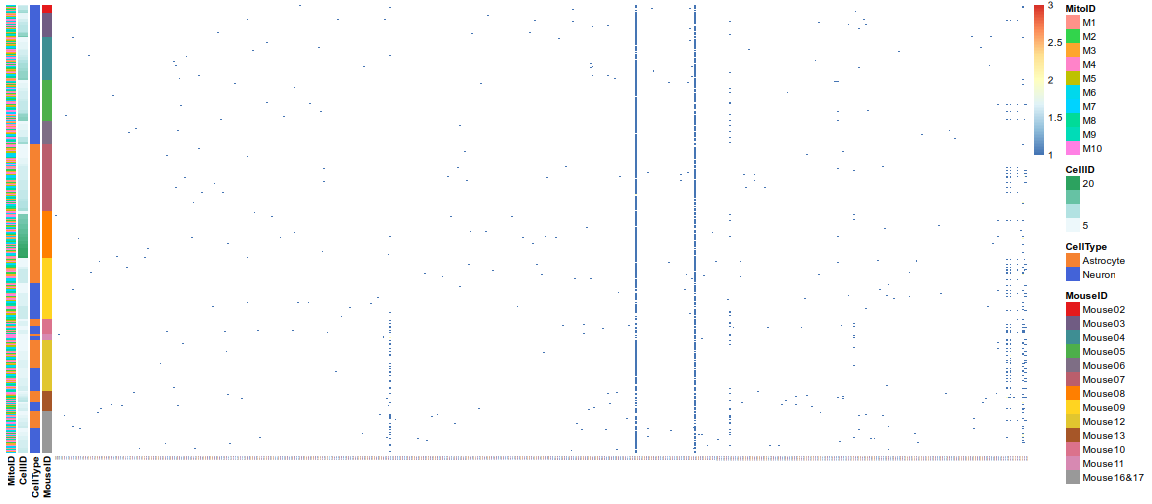

In [38]:
highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos_df <- as.data.frame(highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos[, -c(1:19)])
highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos_df[highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos_df == 0] <- NA
rownames(highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos_df) <- highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos[, LibraryMitoID]
MitoInfo_df <- as.data.frame(MitoInfo)
rownames(MitoInfo_df) <- MitoInfo_df$LibraryMitoID
MitoInfo_df$MitoID <- factor(MitoInfo_df$MitoID, levels = mitoIDs)
MitoInfo_df$CellID <- as.integer(MitoInfo_df$CellID)
highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos_df <- highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos_df[highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos[, order(MouseID, CellType, CellID, MitoID)], ]
options(repr.plot.width = 16, repr.plot.height = 7, repr.plot.res = 72)
pheatmap(highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = MitoInfo_df[rownames(highdepth_highaf_somatic_noctrl_nvaralleles_bymito_bypos_df), c("MouseID", "CellType", "CellID", "MitoID")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 2, show_rownames = FALSE, na_col = "#FFFFFFFF")

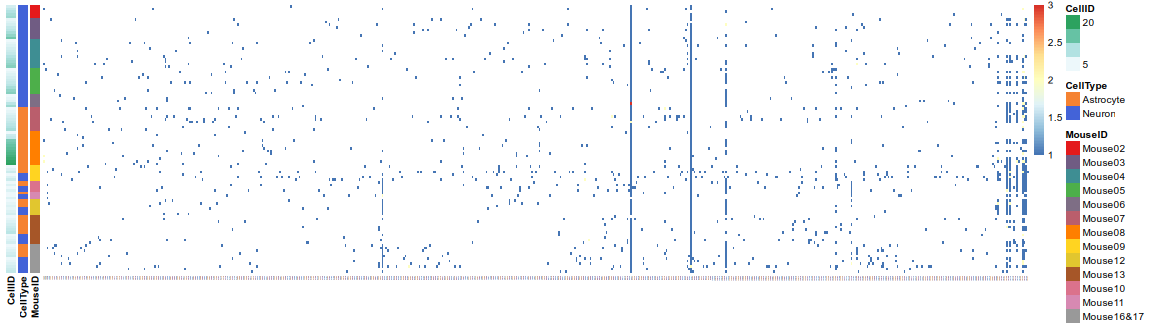

In [39]:
highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos_df <- as.data.frame(highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos[, -c(1:7)])
highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos_df[highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos_df == 0] <- NA
rownames(highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos_df) <- highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos[, CellUID]
highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos_df <- highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos_df[highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos[, order(MouseID, CellType, CellID)], ]
options(repr.plot.width = 16, repr.plot.height = 4.5, repr.plot.res = 72)
pheatmap(highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = CellInfo_df[rownames(highdepth_highaf_somatic_noctrl_nvaralleles_bycell_bypos_df), c("MouseID", "CellType", "CellID")], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 2, show_rownames = FALSE, na_col = "#FFFFFFFF")

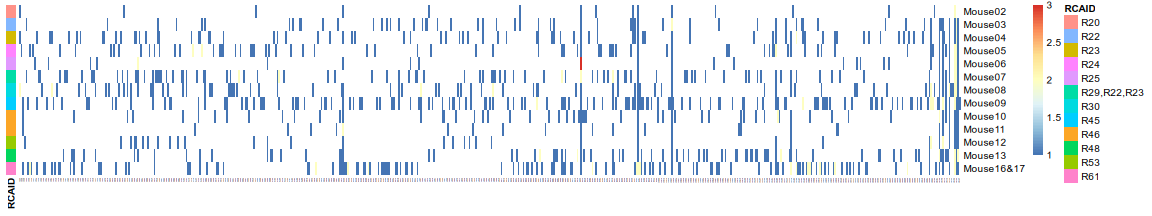

In [40]:
highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df <- as.data.frame(highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos)
highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df[highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df == 0] <- NA
rownames(highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df) <- highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos[, MouseID]
highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df <- highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df[, -c(1:2)]
highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df <- highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df[highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos[, order(MouseID)], ]
options(repr.plot.width = 16, repr.plot.height = 3, repr.plot.res = 72)
pheatmap(highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df, cluster_col = FALSE, cluster_row = FALSE, angle = 90, annotation_row = MouseInfo_df[rownames(highdepth_highaf_somatic_noctrl_nvaralleles_bymouse_bypos_df), c("RCAID"), drop = FALSE], annotation_color = list(MouseID = structure(colorRampPalette(scales::brewer_pal(palette = "Set1")(9))(length(MouseInfo[, MouseID])), names = MouseInfo[, MouseID]), CellType = c("Astrocyte" = Graphics$palette20[5], "Neuron" = Graphics$palette20[4])), fontsize_col = 2, show_rownames = TRUE, na_col = "#FFFFFFFF")

## Per-SNV stats

In [41]:
highdepth_noctrl_hasdata_bymito_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymito_byposmut.csv.gz", header = TRUE)
highdepth_noctrl_hasdata_bycell_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bycell_byposmut.csv.gz", header = TRUE)
highdepth_noctrl_hasdata_bymouse_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_hasdata_bymouse_byposmut.csv.gz", header = TRUE)
highdepth_noctrl_nmitoshasdata_bycell_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_nmitoshasdata_bycell_byposmut.csv.gz")
highdepth_noctrl_ncellshasdata_bymouse_byposmut <- fread(file = "Report/SNVs/QC/highdepth_noctrl_ncellshasdata_bymouse_byposmut.csv.gz")
highdepth_highaf_noctrl_hassnv_bymito_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bymito_byposmut.csv.gz")
highdepth_highaf_noctrl_hassnv_bycell_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bycell_byposmut.csv.gz")
highdepth_highaf_noctrl_hassnv_bymouse_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_hassnv_bymouse_byposmut.csv.gz")
highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut.csv.gz")
highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut.csv.gz")
highdepth_highaf_noctrl_fmitoshassnv_bycell_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_fmitoshassnv_bycell_byposmut.csv.gz")
highdepth_highaf_noctrl_fcellshassnv_bymouse_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_fcellshassnv_bymouse_byposmut.csv.gz")
highdepth_highaf_noctrl_fmitoshasdatahassnv_bycell_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_fmitoshasdatahassnv_bycell_byposmut.csv.gz")
highdepth_highaf_noctrl_fcellshasdatahassnv_bymouse_byposmut <- fread(file = "Report/SNVs/QC/highdepth_highaf_noctrl_fcellshasdatahassnv_bymouse_byposmut.csv.gz")

1. Inherited SNVs

In [ ]:
highdepth_inherited_noctrl_hasdata_bymito_byposmut <- data.table(highdepth_noctrl_hasdata_bymito_byposmut[, 1:19], highdepth_noctrl_hasdata_bymito_byposmut[, match(posmut_inherited, names(highdepth_noctrl_hasdata_bymito_byposmut)), with = FALSE])
highdepth_inherited_noctrl_hasdata_bycell_byposmut <- data.table(highdepth_noctrl_hasdata_bycell_byposmut[, 1:7], highdepth_noctrl_hasdata_bycell_byposmut[, match(posmut_inherited, names(highdepth_noctrl_hasdata_bycell_byposmut)), with = FALSE])
highdepth_inherited_noctrl_hasdata_bymouse_byposmut <- data.table(highdepth_noctrl_hasdata_bymouse_byposmut[, 1:2], highdepth_noctrl_hasdata_bymouse_byposmut[, match(posmut_inherited, names(highdepth_noctrl_hasdata_bymouse_byposmut)), with = FALSE])
fwrite(highdepth_inherited_noctrl_hasdata_bymito_byposmut, file = "Report/SNVs/origin/highdepth_inherited_noctrl_hasdata_bymito_byposmut.csv")
fwrite(highdepth_inherited_noctrl_hasdata_bycell_byposmut, file = "Report/SNVs/origin/highdepth_inherited_noctrl_hasdata_bycell_byposmut.csv")
fwrite(highdepth_inherited_noctrl_hasdata_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_inherited_noctrl_hasdata_bymouse_byposmut.csv")

In [ ]:
highdepth_inherited_noctrl_nmitoshasdata_bycell_byposmut <- data.table(highdepth_noctrl_nmitoshasdata_bycell_byposmut[, 1:7], highdepth_noctrl_nmitoshasdata_bycell_byposmut[, match(posmut_inherited, names(highdepth_noctrl_nmitoshasdata_bycell_byposmut)), with = FALSE])
highdepth_inherited_noctrl_ncellshasdata_bymouse_byposmut <- data.table(highdepth_noctrl_ncellshasdata_bymouse_byposmut[, 1:2], highdepth_noctrl_ncellshasdata_bymouse_byposmut[, match(posmut_inherited, names(highdepth_noctrl_ncellshasdata_bymouse_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_hassnv_bymito_byposmut <- data.table(highdepth_highaf_noctrl_hassnv_bymito_byposmut[, 1:19], highdepth_highaf_noctrl_hassnv_bymito_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_hassnv_bymito_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_hassnv_bycell_byposmut <- data.table(highdepth_highaf_noctrl_hassnv_bycell_byposmut[, 1:7], highdepth_highaf_noctrl_hassnv_bycell_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_hassnv_bycell_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_hassnv_bymouse_byposmut <- data.table(highdepth_highaf_noctrl_hassnv_bymouse_byposmut[, 1:2], highdepth_highaf_noctrl_hassnv_bymouse_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_hassnv_bymouse_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_nmitoshassnv_bycell_byposmut <- data.table(highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut[, 1:7], highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_ncellshassnv_bymouse_byposmut <- data.table(highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut[, 1:2], highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_fmitoshassnv_bycell_byposmut <- data.table(highdepth_highaf_noctrl_fmitoshassnv_bycell_byposmut[, 1:7], highdepth_highaf_noctrl_fmitoshassnv_bycell_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_fmitoshassnv_bycell_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_fcellshassnv_bymouse_byposmut <- data.table(highdepth_highaf_noctrl_fcellshassnv_bymouse_byposmut[, 1:2], highdepth_highaf_noctrl_fcellshassnv_bymouse_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_fcellshassnv_bymouse_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_fmitoshasdatahassnv_bycell_byposmut <- data.table(highdepth_highaf_noctrl_fmitoshasdatahassnv_bycell_byposmut[, 1:7], highdepth_highaf_noctrl_fmitoshasdatahassnv_bycell_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_fmitoshasdatahassnv_bycell_byposmut)), with = FALSE])
highdepth_highaf_inherited_noctrl_fcellshasdatahassnv_bymouse_byposmut <- data.table(highdepth_highaf_noctrl_fcellshasdatahassnv_bymouse_byposmut[, 1:2], highdepth_highaf_noctrl_fcellshasdatahassnv_bymouse_byposmut[, match(posmut_inherited, names(highdepth_highaf_noctrl_fcellshasdatahassnv_bymouse_byposmut)), with = FALSE])

fwrite(highdepth_inherited_noctrl_nmitoshasdata_bycell_byposmut, file = "Report/SNVs/origin/highdepth_inherited_noctrl_nmitoshasdata_bycell_byposmut.csv")
fwrite(highdepth_inherited_noctrl_ncellshasdata_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_inherited_noctrl_ncellshasdata_bymouse_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_hassnv_bymito_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_hassnv_bymito_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_hassnv_bycell_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_hassnv_bycell_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_hassnv_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_hassnv_bymouse_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_nmitoshassnv_bycell_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_nmitoshassnv_bycell_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_ncellshassnv_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_ncellshassnv_bymouse_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_fmitoshassnv_bycell_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_fmitoshassnv_bycell_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_fcellshassnv_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_fcellshassnv_bymouse_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_fmitoshasdatahassnv_bycell_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_fmitoshasdatahassnv_bycell_byposmut.csv")
fwrite(highdepth_highaf_inherited_noctrl_fcellshasdatahassnv_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_highaf_inherited_noctrl_fcellshasdatahassnv_bymouse_byposmut.csv")

2. Somatic SNVs

In [ ]:
highdepth_somatic_noctrl_hasdata_bymito_byposmut <- data.table(highdepth_noctrl_hasdata_bymito_byposmut[, 1:19], highdepth_noctrl_hasdata_bymito_byposmut[, match(posmut_somatic, names(highdepth_noctrl_hasdata_bymito_byposmut)), with = FALSE])
highdepth_somatic_noctrl_hasdata_bycell_byposmut <- data.table(highdepth_noctrl_hasdata_bycell_byposmut[, 1:7], highdepth_noctrl_hasdata_bycell_byposmut[, match(posmut_somatic, names(highdepth_noctrl_hasdata_bycell_byposmut)), with = FALSE])
highdepth_somatic_noctrl_hasdata_bymouse_byposmut <- data.table(highdepth_noctrl_hasdata_bymouse_byposmut[, 1:2], highdepth_noctrl_hasdata_bymouse_byposmut[, match(posmut_somatic, names(highdepth_noctrl_hasdata_bymouse_byposmut)), with = FALSE])
fwrite(highdepth_somatic_noctrl_hasdata_bymito_byposmut, file = "Report/SNVs/origin/highdepth_somatic_noctrl_hasdata_bymito_byposmut.csv")
fwrite(highdepth_somatic_noctrl_hasdata_bycell_byposmut, file = "Report/SNVs/origin/highdepth_somatic_noctrl_hasdata_bycell_byposmut.csv")
fwrite(highdepth_somatic_noctrl_hasdata_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_somatic_noctrl_hasdata_bymouse_byposmut.csv")

In [ ]:
highdepth_somatic_noctrl_nmitoshasdata_bycell_byposmut <- data.table(highdepth_noctrl_nmitoshasdata_bycell_byposmut[, 1:7], highdepth_noctrl_nmitoshasdata_bycell_byposmut[, match(posmut_somatic, names(highdepth_noctrl_nmitoshasdata_bycell_byposmut)), with = FALSE])
highdepth_somatic_noctrl_ncellshasdata_bymouse_byposmut <- data.table(highdepth_noctrl_ncellshasdata_bymouse_byposmut[, 1:2], highdepth_noctrl_ncellshasdata_bymouse_byposmut[, match(posmut_somatic, names(highdepth_noctrl_ncellshasdata_bymouse_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_hassnv_bymito_byposmut <- data.table(highdepth_highaf_noctrl_hassnv_bymito_byposmut[, 1:19], highdepth_highaf_noctrl_hassnv_bymito_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_hassnv_bymito_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_hassnv_bycell_byposmut <- data.table(highdepth_highaf_noctrl_hassnv_bycell_byposmut[, 1:7], highdepth_highaf_noctrl_hassnv_bycell_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_hassnv_bycell_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_hassnv_bymouse_byposmut <- data.table(highdepth_highaf_noctrl_hassnv_bymouse_byposmut[, 1:2], highdepth_highaf_noctrl_hassnv_bymouse_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_hassnv_bymouse_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_nmitoshassnv_bycell_byposmut <- data.table(highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut[, 1:7], highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_nmitoshassnv_bycell_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_ncellshassnv_bymouse_byposmut <- data.table(highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut[, 1:2], highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_ncellshassnv_bymouse_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_fmitoshassnv_bycell_byposmut <- data.table(highdepth_highaf_noctrl_fmitoshassnv_bycell_byposmut[, 1:7], highdepth_highaf_noctrl_fmitoshassnv_bycell_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_fmitoshassnv_bycell_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_fcellshassnv_bymouse_byposmut <- data.table(highdepth_highaf_noctrl_fcellshassnv_bymouse_byposmut[, 1:2], highdepth_highaf_noctrl_fcellshassnv_bymouse_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_fcellshassnv_bymouse_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_fmitoshasdatahassnv_bycell_byposmut <- data.table(highdepth_highaf_noctrl_fmitoshasdatahassnv_bycell_byposmut[, 1:7], highdepth_highaf_noctrl_fmitoshasdatahassnv_bycell_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_fmitoshasdatahassnv_bycell_byposmut)), with = FALSE])
highdepth_highaf_somatic_noctrl_fcellshasdatahassnv_bymouse_byposmut <- data.table(highdepth_highaf_noctrl_fcellshasdatahassnv_bymouse_byposmut[, 1:2], highdepth_highaf_noctrl_fcellshasdatahassnv_bymouse_byposmut[, match(posmut_somatic, names(highdepth_highaf_noctrl_fcellshasdatahassnv_bymouse_byposmut)), with = FALSE])

fwrite(highdepth_somatic_noctrl_nmitoshasdata_bycell_byposmut, file = "Report/SNVs/origin/highdepth_somatic_noctrl_nmitoshasdata_bycell_byposmut.csv")
fwrite(highdepth_somatic_noctrl_ncellshasdata_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_somatic_noctrl_ncellshasdata_bymouse_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_hassnv_bymito_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_hassnv_bymito_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_hassnv_bycell_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_hassnv_bycell_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_hassnv_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_hassnv_bymouse_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_nmitoshassnv_bycell_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_nmitoshassnv_bycell_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_ncellshassnv_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_ncellshassnv_bymouse_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_fmitoshassnv_bycell_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_fmitoshassnv_bycell_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_fcellshassnv_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_fcellshassnv_bymouse_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_fmitoshasdatahassnv_bycell_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_fmitoshasdatahassnv_bycell_byposmut.csv")
fwrite(highdepth_highaf_somatic_noctrl_fcellshasdatahassnv_bymouse_byposmut, file = "Report/SNVs/origin/highdepth_highaf_somatic_noctrl_fcellshasdatahassnv_bymouse_byposmut.csv")

In [46]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] viridisLite_0.4.2 pheatmap_1.0.12   ggplot2_3.5.1     data.table_1.16.2

loaded via a namespace (and not attached):
 [1] crayon_1.5.3       vctrs_0.6.5        cli_3.6.3  